In [2]:
pip install pandas openpyxl


Note: you may need to restart the kernel to use updated packages.


**Algorithm for Generating Random Polygons for our Data**

In [ ]:
import random
from math import gcd
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull

# Define helper functions

def are_coprime(a, b):
    return gcd(a, b) == 1

def is_point_inside_polygon(x, y, polygon_points):
    n = len(polygon_points)
    inside = False
    p1x, p1y = polygon_points[0]
    for i in range(n + 1):
        p2x, p2y = polygon_points[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside

def generate_random_polygon(num_vertices):
    while True:
        points = []
        while len(points) < num_vertices * 2:  # Generate more points than needed
            x = random.randint(-50, 50)
            y = random.randint(-50, 50)
            if are_coprime(x, y):
                points.append((x, y))
                
        points_array = np.array(points)
        hull = ConvexHull(points_array)
        hull_points = points_array[hull.vertices]
        
        # Ensure the hull has exactly the required number of vertices
        if len(hull_points) == num_vertices:
            # Check if (0, 0) is inside the generated convex hull
            if is_point_inside_polygon(0, 0, hull_points):
                return hull_points.tolist()

def grad(v1, v2):
    return [v1[i] - v2[i] for i in range(len(v1))]

def dp(v1, v2):
    return sum(v1[i] * v2[i] for i in range(len(v1)))

def Euclid(a, b):
    if a < 0:
        a = -a
    if b < 0:
        b = -b
    if b > a:
        a, b = b, a
    if a == 0:
        return b
    if b == 0:
        return a
    n = 1
    while a - b * n > 0:
        n += 1
    if a - b * n == 0:
        return b
    return Euclid(b, a - b * (n - 1))

def TwoDIPN(v1, v2):
    L = grad(v1, v2)
    Lrotate = [-L[1] / Euclid(L[0], L[1]), L[0] / Euclid(L[0], L[1])]
    if dp(Lrotate, v1) > 0:
        Lrotate = grad([0, 0], Lrotate)
    return Lrotate

def Height(v1, v2):
    N = TwoDIPN(v1, v2)
    return int(-dp(N, v1))

def LatticeLength(v1, v2):
    return Euclid(v2[0] - v1[0], v2[1] - v1[1])

def count_t_singularities(polygon_points):
    total_t_singularities = 0
    num_points = len(polygon_points)
    edges = []

    for i in range(num_points):
        v1 = polygon_points[i]
        v2 = polygon_points[(i + 1) % num_points]

        h = Height(v1, v2)
        l = LatticeLength(v1, v2)

        if h == 0:
            t_singularities = 0
        else:
            t_singularities = l // h

        edges.append((v1, v2, h, l, t_singularities))
        total_t_singularities += t_singularities

    return total_t_singularities, edges

def is_point_on_polygon_edge(x, y, polygon_points):
    n = len(polygon_points)
    for i in range(n):
        x1, y1 = polygon_points[i]
        x2, y2 = polygon_points[(i + 1) % n]
        if (x == x1 and y == y1) or (x == x2 and y == y2):
            return True
        if (y - y1) * (x2 - x1) == (y2 - y1) * (x - x1) and min(x1, x2) <= x <= max(x1, x2) and min(y1, y2) <= y <= max(y1, y2):
            return True
    return False

def ehrhart_numbers(polygon_points):
    h1int = 0
    h2int = 0
    h1 = 0
    h2 = 0
    scale_factor = 2

    min_x = min(point[0] for point in polygon_points)
    max_x = max(point[0] for point in polygon_points)
    min_y = min(point[1] for point in polygon_points)
    max_y = max(point[1] for point in polygon_points)

    for x in range(min_x, max_x + 1):
        for y in range(min_y, max_y + 1):
            if is_point_inside_polygon(x, y, polygon_points) or is_point_on_polygon_edge(x, y, polygon_points):
                h1 += 1
                if not is_point_on_polygon_edge(x, y, polygon_points):
                    h1int += 1

    scaled_polygon = [(scale_factor * x, scale_factor * y) for x, y in polygon_points]
    min_x = min(point[0] for point in scaled_polygon)
    max_x = max(point[0] for point in scaled_polygon)
    min_y = min(point[1] for point in scaled_polygon)
    max_y = max(point[1] for point in scaled_polygon)

    for x in range(min_x, max_x + 1):
        for y in range(min_y, max_y + 1):
            if is_point_inside_polygon(x, y, scaled_polygon) or is_point_on_polygon_edge(x, y, scaled_polygon):
                h2 += 1
                if not is_point_on_polygon_edge(x, y, scaled_polygon):
                    h2int += 1

    return h1, h2, h1int, h2int

# Generate and analyze 2000 polygons with exactly 12 t-singularities
num_polygons = 2000
num_vertices = 4
polygons_data = []

while len(polygons_data) < num_polygons:
    polygon = generate_random_polygon(num_vertices)
    t_singularities, edges = count_t_singularities(polygon)
    if t_singularities == 12:
        h1, h2, h1int, h2int = ehrhart_numbers(polygon)
        
        polygons_data.append({
            "Polygon": polygon,
            "t_singularities": t_singularities,
            "h1": h1,
            "h2": h2,
            "h1int": h1int,
            "h2int": h2int,
            "Edges": edges
        })

# Print results
for idx, data in enumerate(polygons_data):
    print(f"Polygon {idx + 1}: Points = {data['Polygon']}")
    print(f"  t-singularities = {data['t_singularities']}, h1 = {data['h1']}, h2 = {data['h2']}, h1int = {data['h1int']}, h2int = {data['h2int']}")
    for edge_idx, (v1, v2, h, l, t_singularities) in enumerate(data["Edges"]):
        print(f"  Edge {edge_idx + 1}: Points = {v1}, {v2}, h = {h}, l = {l}, t-singularities = {t_singularities}")

# Prepare data for Excel
excel_data = [{
    "h1": data["h1"],
    "h2": data["h2"],
    "h1int": data["h1int"],
    "h2int": data["h2int"],
    "n": data["t_singularities"],
    "points" : data["Polygon"]
} for data in polygons_data]

# Convert to DataFrame
df = pd.DataFrame(excel_data)
print(df) 

# Save to Excel
file_path = 'C:/Users/praty/Downloads/01tfano4.xlsx'
df.to_excel(file_path, index=False)


In [15]:
pip install pandas scikit-learn sqlite3


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)
ERROR: No matching distribution found for sqlite3


**Code for Exploratory Data Analysis**

     h1     h2  h1int  h2int   n  \
0  2870  11395   2788  11231  12   
1  3577  14233   3505  14089  12   
2  3895  15517   3835  15397  12   
3  3299  13104   3210  12926  12   
4  4000  15903   3906  15715  12   

                                          points  
0  [[-27, 32], [-37, -22], [-8, -47], [37, -32]]  
1   [[16, 21], [-46, -41], [43, -48], [48, -19]]  
2     [[38, 49], [-50, 37], [46, -35], [46, -5]]  
3      [[7, 38], [-45, 4], [-38, -43], [7, -47]]  
4     [[-43, 41], [-35, -47], [7, -46], [7, 38]]  
Correlation Matrix:
          h1        h2         n
h1  1.000000  0.999964 -0.360026
h2  0.999964  1.000000 -0.363554
n  -0.360026 -0.363554  1.000000
Descriptive Statistics:
                h1            h2            n
count  7979.000000   7979.000000  7979.000000
mean   3209.137862  12768.287755     5.487780
std    1059.038692   4228.128044     3.942326
min     613.000000   2413.000000     0.000000
25%    2468.000000   9802.000000     2.000000
50%    3098.000000  12325

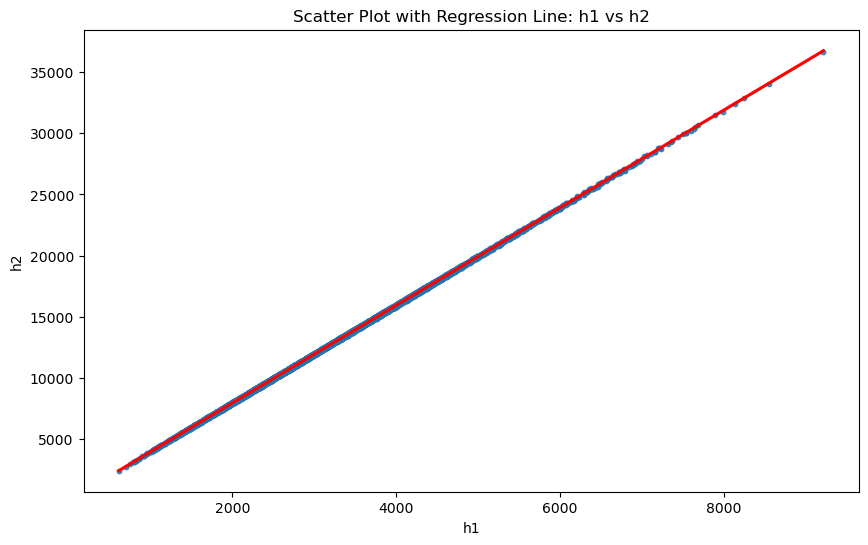

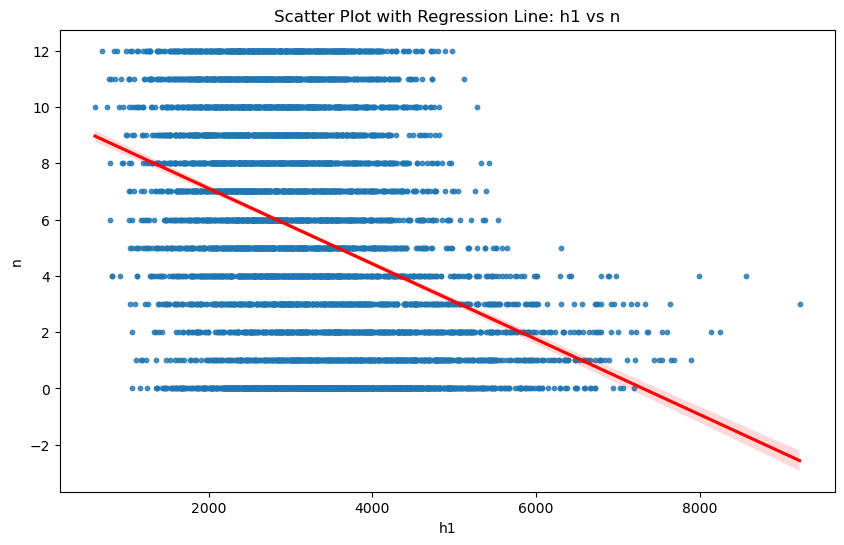

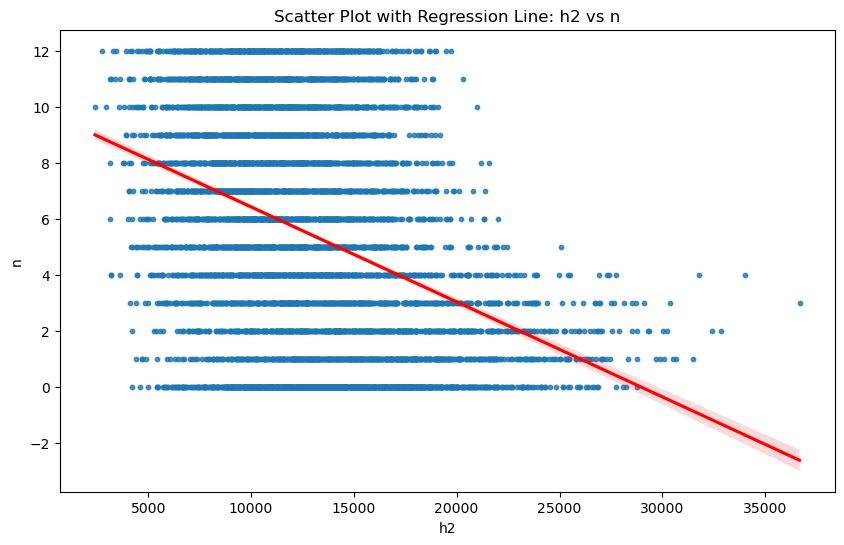

Pearson Correlation (h1, h2): 0.9999635497272485, P-value: 0.0
Pearson Correlation (h1, n): -0.3600260775566273, P-value: 8.42757587177251e-243
Pearson Correlation (h2, n): -0.36355442190420534, P-value: 6.809113665177173e-248


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Load the data from the Excel file
file_path = "C:/Users/praty/Downloads/allfinalfanodata.xlsx"
df = pd.read_excel(file_path)

# Display the first few rows of the dataframe
print(df.head())

# Calculate the correlation matrix
correlation_matrix = df[['h1', 'h2', 'n']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Calculate descriptive statistics
descriptive_stats = df[['h1', 'h2', 'n']].describe()
print("Descriptive Statistics:")
print(descriptive_stats)

# Scatter plot with regression line for h1 vs h2
plt.figure(figsize=(10, 6))
sns.regplot(x='h1', y='h2', data=df, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Scatter Plot with Regression Line: h1 vs h2')
plt.xlabel('h1')
plt.ylabel('h2')
plt.show()

# Scatter plot with regression line for h1 vs n
plt.figure(figsize=(10, 6))
sns.regplot(x='h1', y='n', data=df, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Scatter Plot with Regression Line: h1 vs n')
plt.xlabel('h1')
plt.ylabel('n')
plt.show()

# Scatter plot with regression line for h2 vs n
plt.figure(figsize=(10, 6))
sns.regplot(x='h2', y='n', data=df, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Scatter Plot with Regression Line: h2 vs n')
plt.xlabel('h2')
plt.ylabel('n')
plt.show()

# Calculate Pearson correlation coefficients and p-values
corr_h1_h2, p_value_h1_h2 = pearsonr(df['h1'], df['h2'])
corr_h1_n, p_value_h1_n = pearsonr(df['h1'], df['n'])
corr_h2_n, p_value_h2_n = pearsonr(df['h2'], df['n'])

print(f"Pearson Correlation (h1, h2): {corr_h1_h2}, P-value: {p_value_h1_h2}")
print(f"Pearson Correlation (h1, n): {corr_h1_n}, P-value: {p_value_h1_n}")
print(f"Pearson Correlation (h2, n): {corr_h2_n}, P-value: {p_value_h2_n}")


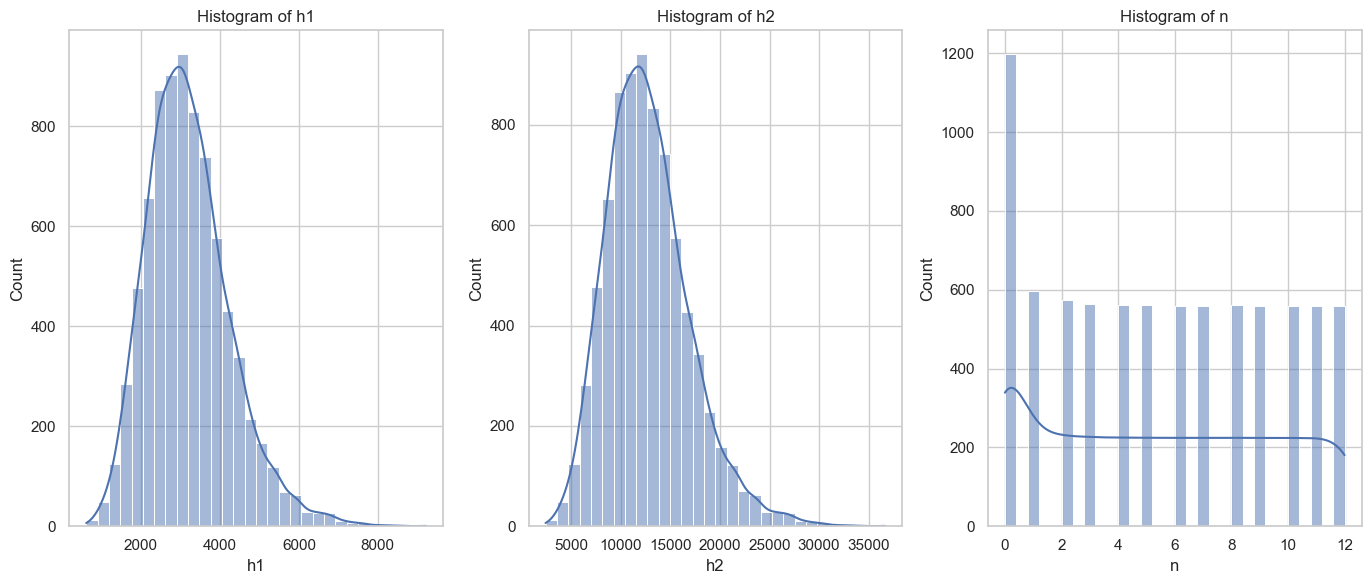

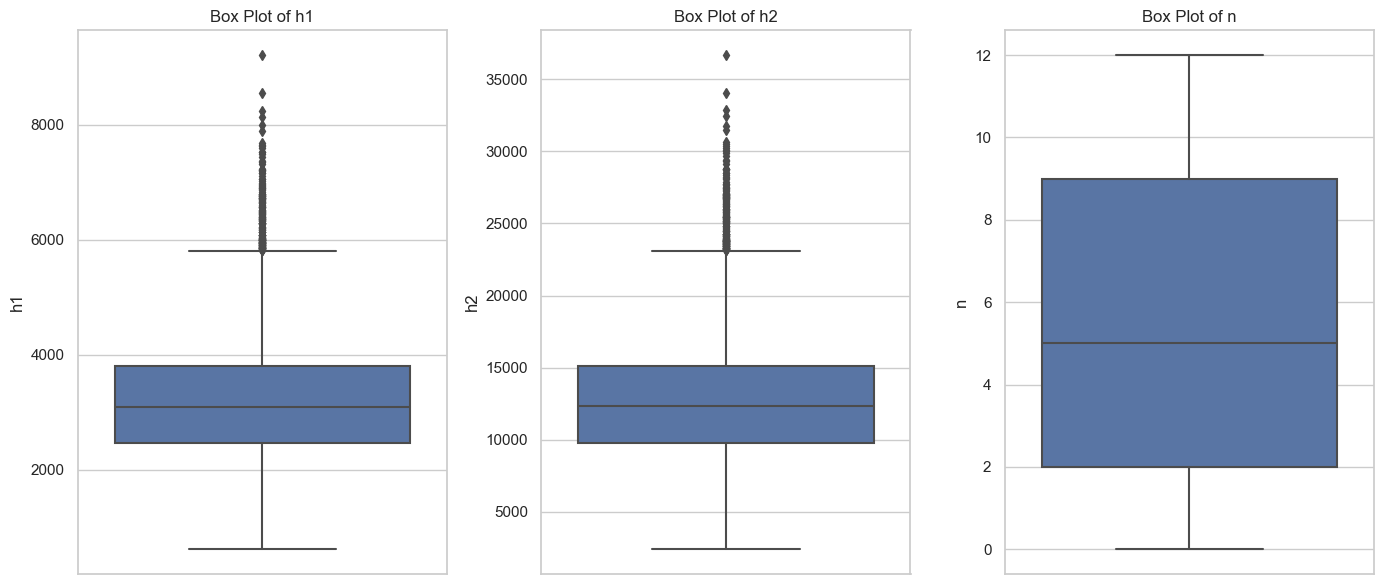

C:\Users\praty\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


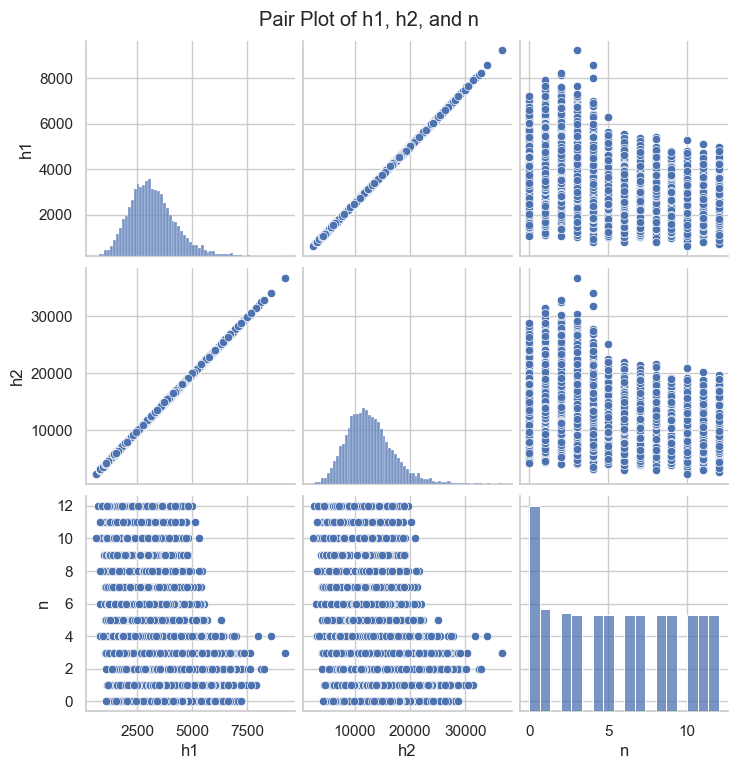

In [3]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Histograms
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
sns.histplot(df['h1'], kde=True, bins=30)
plt.title('Histogram of h1')

plt.subplot(1, 3, 2)
sns.histplot(df['h2'], kde=True, bins=30)
plt.title('Histogram of h2')

plt.subplot(1, 3, 3)
sns.histplot(df['n'], kde=True, bins=30)
plt.title('Histogram of n')

plt.tight_layout()
plt.show()

# Box plots
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
sns.boxplot(y=df['h1'])
plt.title('Box Plot of h1')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['h2'])
plt.title('Box Plot of h2')

plt.subplot(1, 3, 3)
sns.boxplot(y=df['n'])
plt.title('Box Plot of n')

plt.tight_layout()
plt.show()

# Pair plot
sns.pairplot(df[['h1', 'h2', 'n']])
plt.suptitle('Pair Plot of h1, h2, and n', y=1.02)
plt.show()


Correlation Matrix:
          h1        h2         n
h1  1.000000  0.999964 -0.360026
h2  0.999964  1.000000 -0.363554
n  -0.360026 -0.363554  1.000000


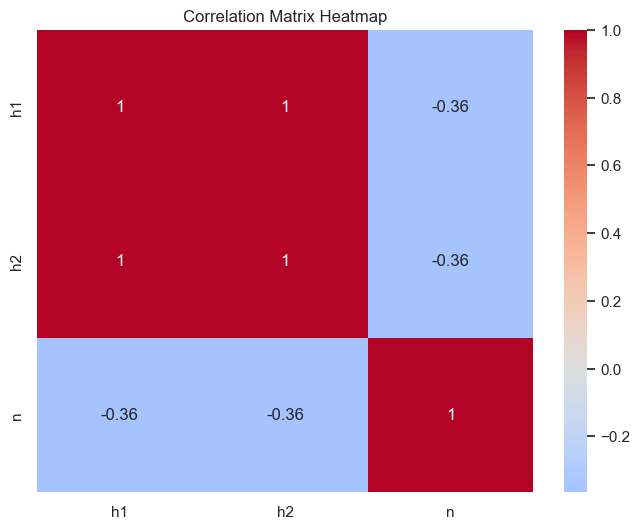

In [4]:
correlation_matrix = df[['h1', 'h2', 'n']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Heatmap of the Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

**Code for Model Training and Evaluation**

In [8]:
from sklearn.cluster import KMeans


In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Load the data
df = pd.read_excel('C:/Users/praty/Downloads/allfinalfanodata.xlsx')

# Define features and target
X = df[['h1', 'h2','h1int', 'h2int']]
y = df['n']

# Binarize the target variable (example: thresholding)
threshold = 0.5  # or choose any other threshold
y_binary = (y > threshold).astype(int)  # 1 if above threshold, 0 otherwise

# Generate polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Split the data ensuring the distribution of the target variable
X_train, X_test, y_train, y_test = train_test_split(X_poly, y_binary, test_size=0.3, random_state=42, stratify=y_binary)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVC': SVC(),
    'KMeans': KMeans(n_clusters=2, random_state=42)
}

# Parameters for GridSearchCV
params = {
    'Logistic Regression': {'C': [0.1, 1.0, 10.0]},
    'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30]},
    'Gradient Boosting': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2]},
    'SVC': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
}

# Train and evaluate models
for name, model in models.items():
    print(f"Training {name}...")
    if name in params:
        grid_search = GridSearchCV(model, params[name], cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = model
        if name == 'KMeans':
            best_model.fit(X_train)
        else:
            best_model.fit(X_train, y_train)
    
    # Predictions
    if name == 'KMeans':
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
        
        # Mapping clusters to binary labels
        # Assuming cluster 0 should be mapped to 0 and cluster 1 to 1, adjust if necessary
        if accuracy_score(y_train, y_train_pred) < 0.5:
            y_train_pred = 1 - y_train_pred
            y_test_pred = 1 - y_test_pred
    else:
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
    
    # Performance metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    # Cross-Validation Scores
    cv_scores = cross_val_score(best_model, X_poly, y_binary, cv=5, scoring='accuracy')
    
    # Results
    print(f"{name} - Train Accuracy: {train_accuracy}, Train F1: {train_f1}")
    print(f"{name} - Test Accuracy: {test_accuracy}, Test F1: {test_f1}")
    print(f"{name} - CV Accuracy Scores: {cv_scores}")
    print(f"{name} - Average CV Accuracy: {cv_scores.mean()}\n")

    # Additional Metrics
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_test_pred)}")
    print(f"Classification Report:\n{classification_report(y_test, y_test_pred)}\n")

Training Logistic Regression...
Logistic Regression - Train Accuracy: 0.9547000895255148, Train F1: 0.97345504144371
Logistic Regression - Test Accuracy: 0.9527986633249791, Test F1: 0.972160630697216
Logistic Regression - CV Accuracy Scores: [0.94924812 0.94548872 0.94799499 0.96052632 0.95485893]
Logistic Regression - Average CV Accuracy: 0.9516234159065377

Confusion Matrix:
[[ 308   51]
 [  62 1973]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       359
           1       0.97      0.97      0.97      2035

    accuracy                           0.95      2394
   macro avg       0.90      0.91      0.91      2394
weighted avg       0.95      0.95      0.95      2394


Training Random Forest...
Random Forest - Train Accuracy: 0.9983885407341092, Train F1: 0.999052731291443
Random Forest - Test Accuracy: 0.9181286549707602, Test F1: 0.9524733268671193
Random Forest - CV Accuracy Scores: [0.9160401  0.911027

**Importing Data from SQL and Training Logistic Regression with GridSearchCV**

In [38]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score


df = pd.read_excel('C:/Users/praty/Downloads/allfinalfanodata.xlsx')

# Creating and connecting to an SQLite database
conn = sqlite3.connect('fanodata.db')

# Write the DataFrame to an SQL table
df.to_sql('fanodata', conn, if_exists='replace', index=False)

# Verify that the data was loaded correctly
query = "SELECT * FROM fanodata LIMIT 5;"
df_sql = pd.read_sql(query, conn)
print("Sample data from SQL database:")
print(df_sql.head())

# Fetch all data for machine learning
query = "SELECT * FROM fanodata;"
df = pd.read_sql(query, conn)

# Close the database connection
conn.close()

# Step 4: Define features and target
X = df[['h1', 'h2', 'h1int', 'h2int']]
y = df['n']

# Binarize the target variable (example: thresholding)
threshold = 0.5
y_binary = (y > threshold).astype(int)  # 1 if above threshold, 0 otherwise

# Step 5: Generate polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Step 6: Scale the features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Step 7: Apply PCA
pca = PCA(n_components=3)
X_pca_reduced = pca.fit_transform(X_poly_scaled)
loadings = pca.components_
loading_df= pd.DataFrame(loadings.T,columns=[f'PC{i+1}' for i in range (loadings.shape[0])],
                         index=poly.get_feature_names_out())
# Step 8: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca_reduced, y_binary, test_size=0.3, random_state=42, stratify=y_binary)

# Step 9: Train Logistic Regression with GridSearchCV
log_reg = LogisticRegression(max_iter=1000)
params = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
grid_search = GridSearchCV(log_reg, params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(best_model.coef_)
# Step 10: Predict on the test set and evaluate
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model accuracy on test set: {accuracy * 100:.2f}%")

# Optional: Display classification report or other metrics

 # Additional Metrics
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}\n")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(loading_df)

Sample data from SQL database:
     h1     h2  h1int  h2int   n  \
0  2870  11395   2788  11231  12   
1  3577  14233   3505  14089  12   
2  3895  15517   3835  15397  12   
3  3299  13104   3210  12926  12   
4  4000  15903   3906  15715  12   

                                          points  
0  [[-27, 32], [-37, -22], [-8, -47], [37, -32]]  
1   [[16, 21], [-46, -41], [43, -48], [48, -19]]  
2     [[38, 49], [-50, 37], [46, -35], [46, -5]]  
3      [[7, 38], [-45, 4], [-38, -43], [7, -47]]  
4     [[-43, 41], [-35, -47], [7, -46], [7, 38]]  
[[ -0.16635222  -1.37373292 103.24744992]]
Model accuracy on test set: 94.70%
Confusion Matrix:
[[3817  117]
 [ 241 2586]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      3934
           1       0.96      0.91      0.94      2827

    accuracy                           0.95      6761
   macro avg       0.95      0.94      0.95      6761
weighted avg       0.95     

Code for plotting Decision Boundaries

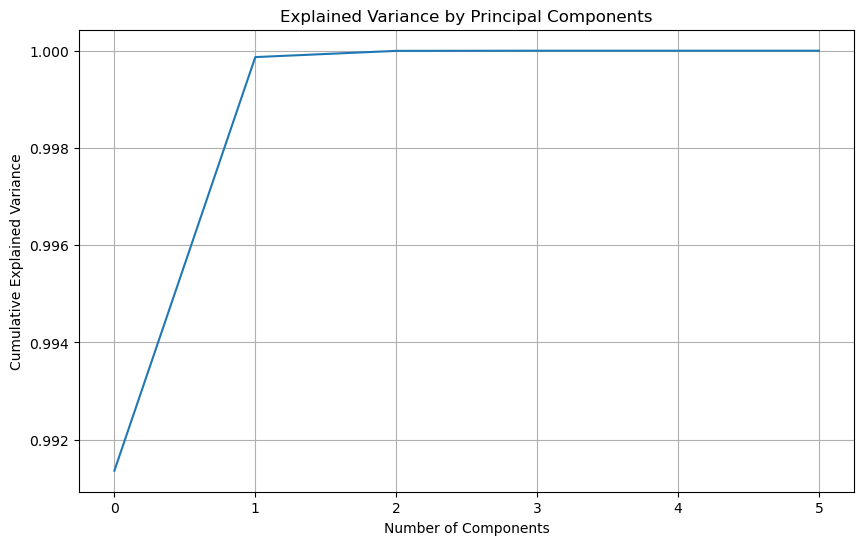

Accuracy for PC1 vs PC2: 60.61%
Accuracy for PC1 vs PC3: 94.45%
Accuracy for PC1 vs PC4: 76.20%
Accuracy for PC1 vs PC5: 59.30%
Accuracy for PC1 vs PC6: 59.31%
Accuracy for PC2 vs PC3: 94.60%
Accuracy for PC2 vs PC4: 66.74%
Accuracy for PC2 vs PC5: 66.88%
Accuracy for PC2 vs PC6: 59.65%
Accuracy for PC3 vs PC4: 93.89%
Accuracy for PC3 vs PC5: 93.92%
Accuracy for PC3 vs PC6: 93.88%
Accuracy for PC4 vs PC5: 78.46%
Accuracy for PC4 vs PC6: 65.97%
Accuracy for PC5 vs PC6: 69.50%


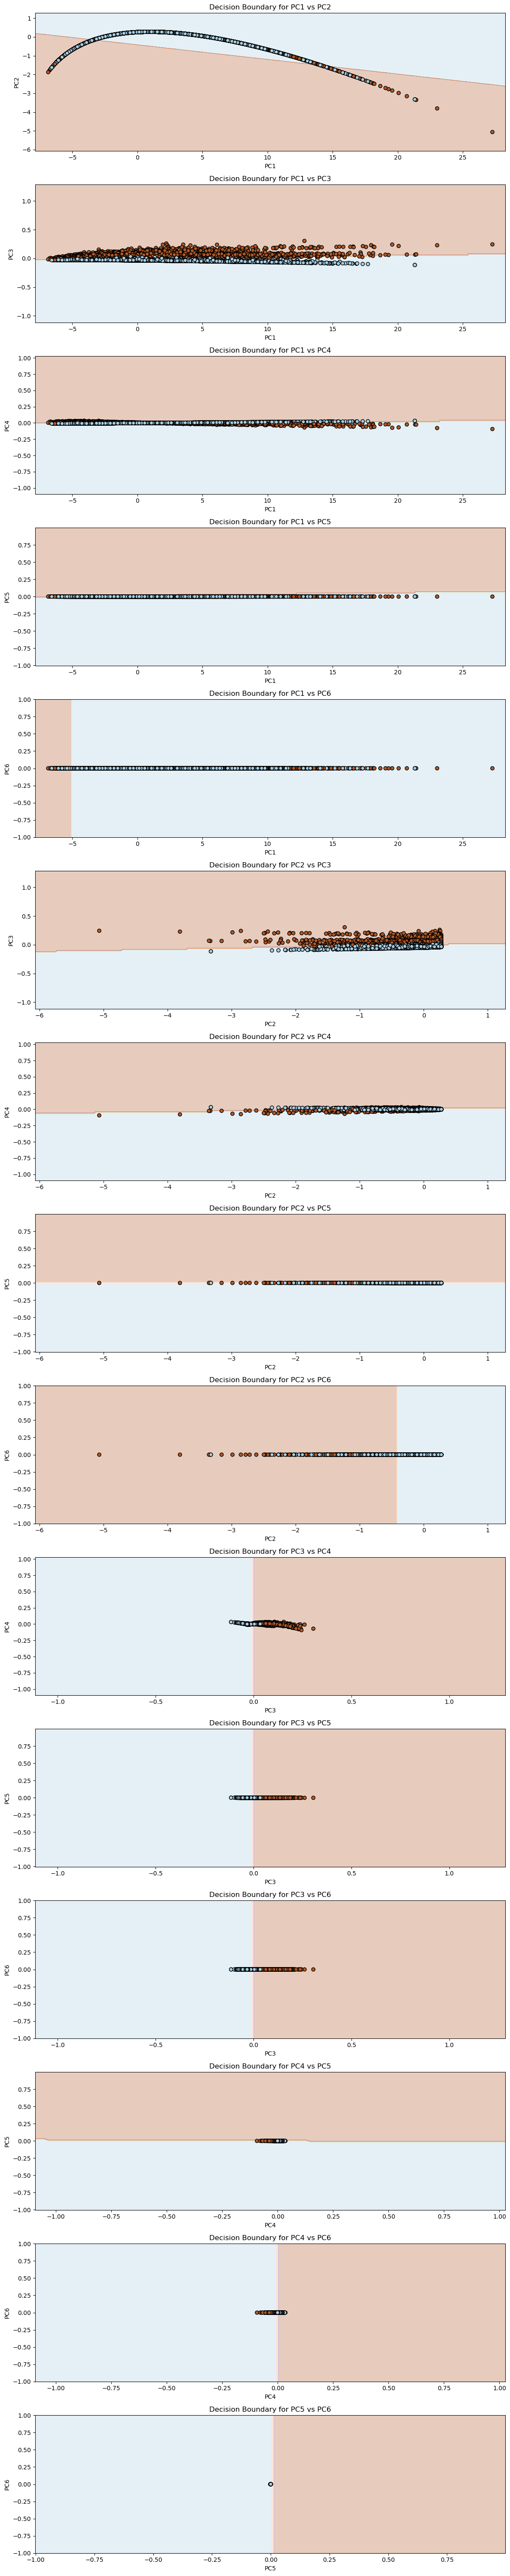

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, log_loss
import matplotlib.pyplot as plt
import itertools

# Load the data
df = pd.read_excel('C:/Users/praty/Downloads/allfinalfanodata.xlsx')

# Define features and target
X = df[['h1', 'h2', 'h1int', 'h2int']]
y = df['n']

# Binarize the target variable (example: thresholding)
threshold = 0.5  # or choose any other threshold
y_binary = (y > threshold).astype(int)  # 1 if above threshold, 0 otherwise

# Generate polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)  # include_bias=False to avoid adding a bias term
X_poly = poly.fit_transform(X)

# Scale the features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Apply PCA
pca = PCA(n_components=6)
X_pca_reduced = pca.fit_transform(X_poly_scaled)
loadings = pca.components_
loading_df= pd.DataFrame(loadings.T,columns=[f'PC{i+1}' for i in range (loadings.shape[0])],
                         index=poly.get_feature_names_out())
# Plot the explained variance ratio to determine the number of components to keep
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Split the data ensuring the distribution of the target variable
X_train, X_test, y_train, y_test = train_test_split(X_pca_reduced, y_binary, test_size=0.3, random_state=42, stratify=y_binary)

# Parameters for GridSearchCV for Logistic Regression
params = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Function to plot decision boundary for each pair of PCA components
def plot_pairwise_decision_boundaries(X, y, n_components):
    pairs = list(itertools.combinations(range(n_components), 2))
    fig, axes = plt.subplots(len(pairs), 1, figsize=(12, len(pairs) * 4))
    
    for idx, (i, j) in enumerate(pairs):
        X_pair = X[:, [i, j]]
        
        # Train Logistic Regression for this pair of components
        X_train_pair, X_test_pair, y_train_pair, y_test_pair = train_test_split(X_pair, y, test_size=0.3, random_state=42, stratify=y)
        log_reg = LogisticRegression(max_iter=1000)
        grid_search = GridSearchCV(log_reg, params, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_pair, y_train_pair)
        best_model = grid_search.best_estimator_

        # Predict on test set and calculate accuracy
        y_pred_pair = best_model.predict(X_test_pair)
        accuracy = accuracy_score(y_test_pair, y_pred_pair)
        print(f"Accuracy for PC{i+1} vs PC{j+1}: {accuracy * 100:.2f}%")

        # Create a mesh grid for the current pair of components
        h = .02  # step size in the mesh
        x_min, x_max = X_pair[:, 0].min() - 1, X_pair[:, 0].max() + 1
        y_min, y_max = X_pair[:, 1].min() - 1, X_pair[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        # Predict class for each point in the mesh
        Z = best_model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # Plot the decision boundary
        ax = axes[idx]
        ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
        ax.scatter(X_pair[:, 0], X_pair[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired)
        ax.set_xlabel(f'PC{i+1}')
        ax.set_ylabel(f'PC{j+1}')
        ax.set_title(f'Decision Boundary for PC{i+1} vs PC{j+1}')

    plt.tight_layout()
    plt.show()

# Plot decision boundaries for each pair of the 6 components
plot_pairwise_decision_boundaries(X_pca_reduced, y_binary, n_components=6)


In [25]:
pca = PCA(n_components=3)
pca.fit(X_poly_scaled)

# Print the components (eigenvectors)
print("PCA Components:\n", pca.components_)

PCA Components:
 [[ 0.26554145  0.26554911  0.26545719  0.26550701  0.26792188  0.26794177
   0.26797247  0.26796711  0.26795656  0.26797213  0.26797179  0.26794275
   0.26795731  0.26796694]
 [ 0.42053688  0.4221361   0.42675739  0.42524675 -0.16979737 -0.16937694
  -0.16786061 -0.16840866 -0.1689562  -0.16743852 -0.16798709 -0.16591568
  -0.16646615 -0.16701593]
 [ 0.39527394  0.19907168 -0.3903979  -0.1938066   0.40469395  0.30315361
  -0.00343859  0.09906377  0.20204246 -0.10325522 -0.00118542 -0.40465089
  -0.30388455 -0.20268286]]


**Code for checking accuracy of individual T-singularities**

In [14]:
# Initialize a list to store accuracy for each singularity
singularity_accuracies = []

# Loop over each unique 'n' value in the dataset
for singularity in df['n'].unique():
    # Select the rows corresponding to the current singularity
    singularity_mask = (df['n'] == singularity)
    X_singularity = X_pca_reduced[singularity_mask]
    y_singularity = y_binary[singularity_mask]

    # Predict the singularity subset using the trained model
    y_singularity_pred = best_model.predict(X_singularity)
    
    # Calculate accuracy for the current singularity
    accuracy = accuracy_score(y_singularity, y_singularity_pred)
    
    # Store the result
    singularity_accuracies.append((singularity, accuracy))

# Convert the results to a DataFrame for easy viewing
singularity_accuracy_df = pd.DataFrame(singularity_accuracies, columns=['Singularity', 'Accuracy'])

# Display the singularity accuracies
print(singularity_accuracy_df)


    Singularity  Accuracy
0            12  0.886121
1            11  0.874113
2            10  0.873665
3             9  0.889680
4             8  0.893357
5             7  0.907965
6             6  0.923345
7             5  0.910035
8             4  0.929174
9             3  0.942229
10            2  0.959529
11            1  0.918379
12            0  0.972466


**Calculating Erhart coefficient based on PCA Transformed Data**

In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Load the data
df = pd.read_excel('C:/Users/praty/Downloads/allfinalfanodata.xlsx')

# Define features and target
X = df[['h1', 'h2', 'h1int', 'h2int']]
y = df['n']

# Binarize the target variable (example: thresholding)
threshold = 0.5  # or choose any other threshold
y_binary = (y > threshold).astype(int)  # 1 if above threshold, 0 otherwise

# Generate polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)  # include_bias=False to avoid adding a bias term
X_poly = poly.fit_transform(X)

# Scale the features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Apply PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_poly_scaled)

# Compute Ehrhart coefficients as approximations based on the PCA-transformed data
ehrhart_coeffs = np.array([X_pca[:, 0].mean(), X_pca[:, 1].mean(), X_pca[:, 2].mean(), 1])

# Display Ehrhart coefficients for understanding
print("Ehrhart Coefficients (based on PCA-transformed data):", ehrhart_coeffs)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_binary, test_size=0.3, random_state=42, stratify=y_binary)

# Train a logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)  # Using PCA1, PCA2, and PCA3

# Coefficients in terms of Ehrhart numbers
coeffs = log_reg.coef_[0]
intercept = log_reg.intercept_[0]

# Print coefficients in terms of Ehrhart numbers
print("\nLogistic Regression Coefficients in terms of Ehrhart numbers:")
print(f"Coefficient for PCA1: {coeffs[0]} * {ehrhart_coeffs[0]}")
print(f"Coefficient for PCA2: {coeffs[1]} * {ehrhart_coeffs[1]}")
print(f"Coefficient for PCA3: {coeffs[2]} * {ehrhart_coeffs[2]}")
print(f"Intercept: {intercept}")




Ehrhart Coefficients (based on PCA-transformed data): [ 6.05414952e-16 -5.46765378e-16  9.17897357e-16  1.00000000e+00]

Logistic Regression Coefficients in terms of Ehrhart numbers:
Coefficient for PCA1: -0.0856874752360449 * 6.054149519212711e-16
Coefficient for PCA2: -1.2261030529804267 * -5.46765378453898e-16
Coefficient for PCA3: 51.828195892171195 * 9.178973567931355e-16
Intercept: -0.3676755105806976


**Calculate probability using sigmoid function**

In [1]:
import numpy as np

# Logistic regression parameters
intercept = -0.3676755105806976
coeff_pca1 = -0.0856874752360449
coeff_pca2 = -1.2261030529804267
coeff_pca3 = 51.828195892171195

# PCA components (Ehrhart coefficients)
X_pca1 = 6.05414952e-16
X_pca2 = -5.46765378e-16
X_pca3 = 9.17897357e-16

# Calculate logit
logit = (intercept +
         coeff_pca1 * X_pca1 +
         coeff_pca2 * X_pca2 +
         coeff_pca3 * X_pca3)

# Calculate probability using sigmoid function
p = 1 / (1 + np.exp(-logit))

print(f"Calculated probability p: {p:.6f}")


Calculated probability p: 0.409103


In [3]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

# Step 1: Load Data from Excel
file_path = 'C:/Users/praty/Downloads/allfinalfanodata.xlsx'  # Replace with your Excel file path


# Load the data into a DataFrame
df = pd.read_excel(file_path)

# Display the first few rows of the data to verify it's loaded correctly
print("Original Data:")
print(df[['h1', 'h2', 'h1int', 'h2int']].head())

# Step 2: Apply Polynomial Feature Engineering
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[['h1', 'h2', 'h1int', 'h2int']])

# Convert to DataFrame for better visualization
poly_feature_names = poly.get_feature_names_out(input_features=['h1', 'h2', 'h1int', 'h2int'])
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)

# Step 3: Display the first few rows of the polynomial features
print("\nPolynomial Features Data:")
print(poly_df.head())

# Optionally, save the new DataFrame with polynomial features back to Excel
output_file_path = 'polynomial_features_output.xlsx'  # Replace with desired output file path
poly_df.to_excel(output_file_path, index=False)

Original Data:
     h1     h2  h1int  h2int
0  2870  11395   2788  11231
1  3577  14233   3505  14089
2  3895  15517   3835  15397
3  3299  13104   3210  12926
4  4000  15903   3906  15715

Polynomial Features Data:
       h1       h2   h1int    h2int        h1^2       h1 h2    h1 h1int  \
0  2870.0  11395.0  2788.0  11231.0   8236900.0  32703650.0   8001560.0   
1  3577.0  14233.0  3505.0  14089.0  12794929.0  50911441.0  12537385.0   
2  3895.0  15517.0  3835.0  15397.0  15171025.0  60438715.0  14937325.0   
3  3299.0  13104.0  3210.0  12926.0  10883401.0  43230096.0  10589790.0   
4  4000.0  15903.0  3906.0  15715.0  16000000.0  63612000.0  15624000.0   

     h1 h2int         h2^2    h2 h1int     h2 h2int     h1int^2  h1int h2int  \
0  32232970.0  129846025.0  31769260.0  127977245.0   7772944.0   31312028.0   
1  50396353.0  202578289.0  49886665.0  200528737.0  12285025.0   49381945.0   
2  59971315.0  240777289.0  59507695.0  238915249.0  14707225.0   59047495.0   
3  42642874.0

**Plots for Different PCA Components**

Sample data from SQL database:
     h1     h2  h1int  h2int   n  \
0  2870  11395   2788  11231  12   
1  3577  14233   3505  14089  12   
2  3895  15517   3835  15397  12   
3  3299  13104   3210  12926  12   
4  4000  15903   3906  15715  12   

                                          points  
0  [[-27, 32], [-37, -22], [-8, -47], [37, -32]]  
1   [[16, 21], [-46, -41], [43, -48], [48, -19]]  
2     [[38, 49], [-50, 37], [46, -35], [46, -5]]  
3      [[7, 38], [-45, 4], [-38, -43], [7, -47]]  
4     [[-43, 41], [-35, -47], [7, -46], [7, 38]]  
Model accuracy on test set: 94.70%
Confusion Matrix:
[[3817  117]
 [ 241 2586]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      3934
           1       0.96      0.91      0.94      2827

    accuracy                           0.95      6761
   macro avg       0.95      0.94      0.95      6761
weighted avg       0.95      0.95      0.95      6761


PCA Loadings:
 

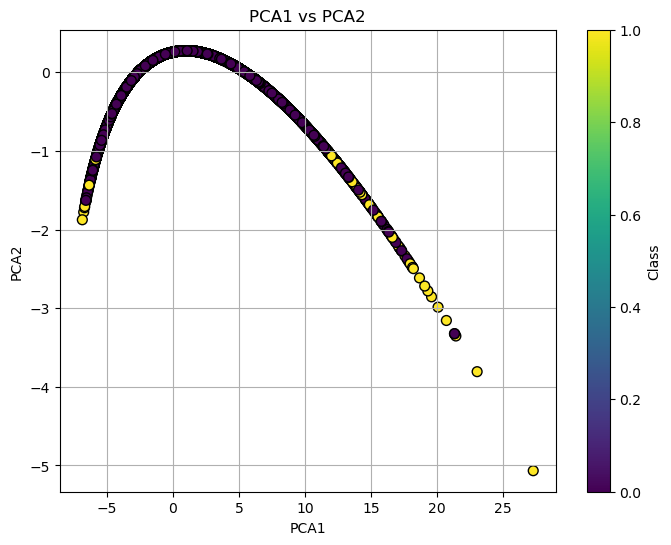

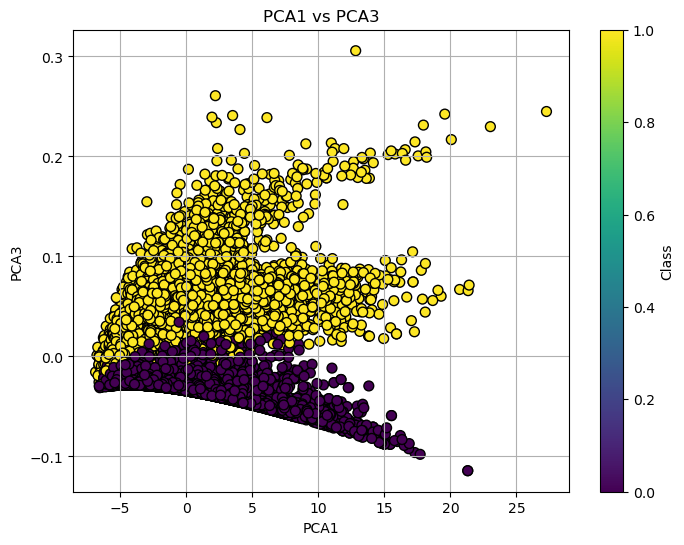

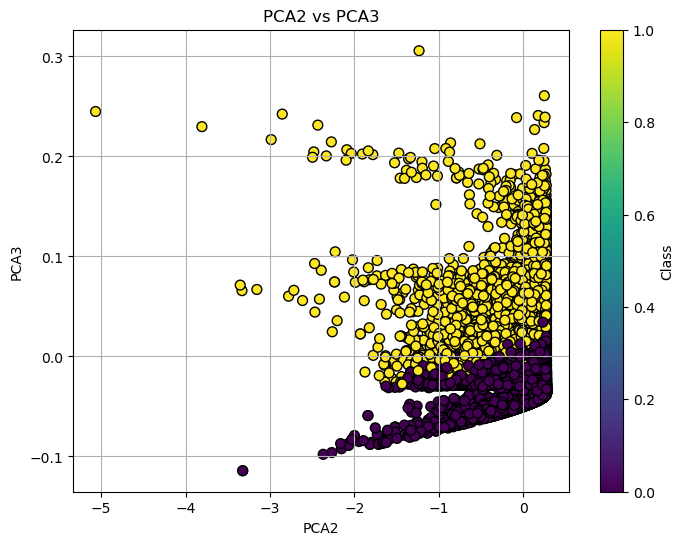

In [4]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Step 1: Load data from Excel
df = pd.read_excel('C:/Users/praty/Downloads/allfinalfanodata.xlsx')

# Step 2: Create and connect to an SQLite database
conn = sqlite3.connect('fanodata.db')

# Step 3: Write the DataFrame to an SQL table
df.to_sql('fanodata', conn, if_exists='replace', index=False)

# Verify that the data was loaded correctly
query = "SELECT * FROM fanodata LIMIT 5;"
df_sql = pd.read_sql(query, conn)
print("Sample data from SQL database:")
print(df_sql.head())

# Fetch all data for machine learning
query = "SELECT * FROM fanodata;"
df = pd.read_sql(query, conn)

# Close the database connection
conn.close()

# Step 4: Define features and target
X = df[['h1', 'h2', 'h1int', 'h2int']]
y = df['n']

# Binarize the target variable (example: thresholding)
threshold = 0.5
y_binary = (y > threshold).astype(int)  # 1 if above threshold, 0 otherwise

# Step 5: Generate polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Step 6: Scale the features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Step 7: Apply PCA
pca = PCA(n_components=3)
X_pca_reduced = pca.fit_transform(X_poly_scaled)
loadings = pca.components_
loading_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])],
                          index=poly.get_feature_names_out())

# Step 8: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca_reduced, y_binary, test_size=0.3, random_state=42, stratify=y_binary)

# Step 9: Train Logistic Regression with GridSearchCV
log_reg = LogisticRegression(max_iter=1000)
params = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
grid_search = GridSearchCV(log_reg, params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Step 10: Predict on the test set and evaluate
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model accuracy on test set: {accuracy * 100:.2f}%")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}\n")
print("PCA Loadings:")
print(loading_df)

# Plotting PCA components
# Plot PCA1 vs PCA2
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], c=y_binary, cmap='viridis', edgecolor='k', s=50)
plt.title('PCA1 vs PCA2')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Class')
plt.grid(True)
plt.show()

# Plot PCA1 vs PCA3
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 2], c=y_binary, cmap='viridis', edgecolor='k', s=50)
plt.title('PCA1 vs PCA3')
plt.xlabel('PCA1')
plt.ylabel('PCA3')
plt.colorbar(label='Class')
plt.grid(True)
plt.show()

# Plot PCA2 vs PCA3
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_reduced[:, 1], X_pca_reduced[:, 2], c=y_binary, cmap='viridis', edgecolor='k', s=50)
plt.title('PCA2 vs PCA3')
plt.xlabel('PCA2')
plt.ylabel('PCA3')
plt.colorbar(label='Class')
plt.grid(True)
plt.show()
